## CS579 Project II LSTM Tuning Road Map

Author: Christopher Hong

* Step 1: Preparing data
  * Step 1.1: Loading data
  * Step 1.2: Partitioning data
  * Step 1.3: Wrangling data
  * Step 1.4: Engineering feature
  * Step 1.5: Encoding label
* Step 2: Cross-validating baseline LSTM model
* Step 3: Tuning LSTM hyperparameters
* Step 4: Assessing final model performance
* Step 5: Saving tuning histories

In [1]:
# Common library
import tensorflow as tf
import pandas as pd
import numpy as np
import os

# Text processing packages
import nltk
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# Visualization packages
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=16)
mpl.rc('xtick', labelsize=14)
mpl.rc('ytick', labelsize=14)

# Machine Learning packages
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import f1_score
import pickle

# Aesthetic setting
pd.set_option("display.max_columns", None)
import warnings
warnings.filterwarnings('ignore')

# Reproducibility setting
np.random.seed(2020)
tf.random.set_seed(2020)
random_state = 2020

# Set up path to local Google Drive
from google.colab import drive
drive.mount('/content/drive')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
Mounted at /content/drive


<a id='1'></a>
## 1 Preparing the data

<a id='1.1'></a>
### 1.1 Loading the data

**Note**: Assume `/content/drive/MyDrive/CS579_Projct_2/option1-data/train.csv` exists.

In [2]:
# Define the base dir to local Google Drive
BASE_PATH = "/content/drive/MyDrive/CS579_Project_2/"

# Define base dir to local drive
DATA_PATH = os.path.join(BASE_PATH, "option1-data")

# Define dir to model dir to store training history
MODEL_PATH = os.path.join(BASE_PATH, "models")

# Create file paths if not extists
os.makedirs(BASE_PATH, exist_ok=True)
os.makedirs(DATA_PATH, exist_ok=True)
os.makedirs(MODEL_PATH, exist_ok=True)

# Define dir to train data
TRAIN_DATA_PATH = os.path.join(DATA_PATH, "train.csv")

print("train data path:", TRAIN_DATA_PATH)

train data path: /content/drive/MyDrive/CS579_Project_2/option1-data/train.csv


In [3]:
# Load train data
df_train = pd.read_csv(TRAIN_DATA_PATH)

# Data quality check
df_train.shape

(256442, 6)

<a id='1.2'></a>
### 1.2 Partitioning the data

In [4]:
# Split the train data into 75/25 train and validation set
test_size= 0.25

# Stratified random sampling
split = StratifiedShuffleSplit(n_splits=1, test_size=test_size, random_state=random_state)
for train_index, val_index in split.split(df_train, df_train['label']):
    data_train = df_train.loc[train_index].copy().reset_index(drop=True)
    data_val = df_train.loc[val_index].copy().reset_index(drop=True)

<a id='1.3'></a>
### 1.3 Normalizing the text feature

In [5]:
def normalize(text):
    """
    Lowercase, tokenize, lemmatize, 
    remove stop and unwanted tokens. 
    """
    # Tokenization 
    lower_tokens = word_tokenize(text.lower())
    
    # Retain alphabetic words
    alpha_tokens = [w for w in lower_tokens if w.isalpha()]
    
    # Create a lemmatizer object
    wordnet_lemmatizer = WordNetLemmatizer()
    
    # Lemmatize all tokens
    lemmatized = [wordnet_lemmatizer.lemmatize(w) for w in alpha_tokens]
    
    # Create a set of stop words
    stop_words = set(stopwords.words('english'))
    
    # Remove stop words and word length less than 3
    no_stops = [w for w in lemmatized if len(w) > 2 and w not in stop_words]
    
    return ' '.join(no_stops)

In [6]:
def normalize_sequences(data, normalize=normalize):
    """
    Combine the normalize title 1 & 2 into one column.
    """
    # Normalize title 1 & 2 columns
    data['title1_en_normalized'] = data['title1_en'].map(normalize)
    data['title2_en_normalized'] = data['title2_en'].map(normalize)

    # Combine train normalized title 1 & 2 columns into one column
    data['title_1_2_normalized'] = \
        data['title1_en_normalized'].str.cat(data['title2_en_normalized'], sep=" ")

    return data.drop(columns=['id', 'tid1', 'tid2'], axis=1)

In [7]:
# Normalize train data
data_train = normalize_sequences(data_train)

# Normalize validation data
data_val = normalize_sequences(data_val)

<a id='1.4'></a>
### 1.4 Vectorizing the text feature

In [8]:
def create_tokenizer(data, num_words):
    """
    Create a vectorizer with vocabulary size of num_words.
    """
    # Create a tokenizer object
    tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=num_words, lower=False)
    # Fit the tokenizer on train text
    tokenizer.fit_on_texts(data['title_1_2_normalized'].values)

    return tokenizer

In [9]:
def vectorize_sequences(data, tokenizer, max_length):
    """
    Vectorize data.
    """
    # Transform text to a sequence of integers
    sequence = tokenizer.texts_to_sequences(data['title_1_2_normalized'].values)
    # Pad the sequence with 0
    X = tf.keras.preprocessing.sequence.pad_sequences(sequence, max_length)

    return X

In [10]:
# Max number of words
num_words = 2000

# Create a tokenizer
tokenizer = create_tokenizer(data_train, num_words)

# Sequece length
max_length = 2**7

# Vectorize train data
X_train = vectorize_sequences(data_train, tokenizer, max_length)

# Vectorize validation data
X_val = vectorize_sequences(data_val, tokenizer, max_length)

# Data quality check
X_train.shape == (data_train.shape[0], max_length)
X_val.shape == (data_val.shape[0], max_length)

True

<a id='1.5'></a>
### 1.5 Encoding the categorical `label`



In [11]:
def to_one_hot(data, num_classes, lab_2_int):
    """
    One-hot encode labels.
    """
    y = data['label'].map(lab_2_int)
    y_one_hot = tf.keras.utils.to_categorical(y, num_classes)

    return y, y_one_hot

In [12]:
# Get target names
target_names = data_train.label.unique().tolist()
print(target_names)

# unrelated -> 0, agreed -> 1, disagreed -> 2
lab_2_int = dict(zip(target_names, range(3)))
print(lab_2_int)

# unrelated <- 0, agreed <- 1, disagreed <- 2
int_2_lab = dict(zip(lab_2_int.values(), lab_2_int.keys()))
print(int_2_lab)

# Encode train label
num_classes = len(target_names)
y_train, y_train_one_hot = to_one_hot(data_train, num_classes, lab_2_int)

# Encode validation label
y_val, y_val_one_hot = to_one_hot(data_val, num_classes, lab_2_int)

# Data quality check
y_train_one_hot.shape == (y_train.shape[0], num_classes)
y_val_one_hot.shape == (y_val.shape[0], num_classes)

['unrelated', 'agreed', 'disagreed']
{'unrelated': 0, 'agreed': 1, 'disagreed': 2}
{0: 'unrelated', 1: 'agreed', 2: 'disagreed'}


True

<a id='2'></a>
## 2 Modeling the data

In [13]:
def kfold_cross_validation(X, y_one_hot, y,
                           num_words,
                           embedding_size,
                           lstm_units,
                           num_output=3,
                           n_splits=3,
                           target_names=['unrelated', 'agreed', 'disagreed']):
    """
    Calculate f1-score using K-fold cross-validation.
    """
    # Create stratified K-fold cross-validator
    skf = StratifiedKFold(n_splits=n_splits, random_state=None)
    # Store K-fold f1-score
    k_f1 = np.array([0.0] * len(target_names))
    # Counter for K
    K = 0
    for train_index, test_index in skf.split(X, y):
        # Extract train and test data
        X_train = X[train_index]
        y_train = y[train_index]
        X_test = X[test_index]
        y_test = y[test_index]
        # Define a sequential model architecture
        model = tf.keras.Sequential()
        model.add(tf.keras.layers.Embedding(num_words, embedding_size, input_length=max_length))
        model.add(tf.keras.layers.LSTM(lstm_units))
        model.add(tf.keras.layers.Dense(num_output, activation='softmax'))
        model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
        # Fit the model
        model.fit(X, y_one_hot,
                  batch_size=128,
                  epochs=6,
                  verbose=0)
        # Predict label
        y_pred = model.predict(X_test)
        y_pred = [np.argmax(y_hat) for y_hat in y_pred]
        # Calculate f1-score
        f1 = f1_score(y_test, y_pred, average=None)
        f1 = f1.round(2)
        k_f1 += f1
        K += 1
        # Print report
        print("Fold {} f1-score {}:{} {}:{} {}:{}".format(K,
            target_names[0], f1[0],
            target_names[1], f1[1],
            target_names[2], f1[2]))
    k_f1 = (k_f1 / n_splits).round(2)
    print("Avg. f1-score {}:{} {}:{} {}:{}".format(
        target_names[0], k_f1[0],
        target_names[1], k_f1[1],
        target_names[2], k_f1[2]))
    return k_f1

In [14]:
def train_lstm(X_train, y_train_one_hot,
               X_val, y_val_one_hot,
               max_features, 
               embedding_size,
               max_length, 
               lstm_units,
               model_name,
               bidirection=False,
               add_layer=False,
               num_output=3, 
               epochs=15,
               verbose=1,
               batch_size=128,
               model_path=MODEL_PATH):
    """
    Define model architecture.
    Complile the defined model.
    Train the model with early stopping.
    """
    # Define a sequential model architecture
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Embedding(max_features, embedding_size, input_length=max_length))
    if bidirection:
        model.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(lstm_units)))
    elif add_layer:
        model.add(tf.keras.layers.LSTM(lstm_units, return_sequences=True))
        model.add(tf.keras.layers.LSTM(lstm_units))
    else:
        model.add(tf.keras.layers.LSTM(lstm_units))
    model.add(tf.keras.layers.Dense(num_output, activation='softmax'))

    # Compile the model
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()

    # Train the model with early stopping
    model_name = os.path.join(model_path, model_name)
    checkpoint = tf.keras.callbacks.ModelCheckpoint(model_name, 
                                                    monitor='val_accuracy',
                                                    mode='max',
                                                    save_best_only=True)
    callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', 
                                                mode='max', 
                                                patience=2, 
                                                restore_best_weights=True)
    history = model.fit(X_train, y_train_one_hot,
                        batch_size=batch_size,
                        epochs=epochs,
                        validation_data=(X_val, y_val_one_hot),
                        callbacks=[callback, checkpoint],
                        verbose=verbose)
    return history, model

In [15]:
def predict_lstm(model, X, y):
    """
    Calculate the f1 score on categories of label.
    """
    y_pred = model.predict(X)
    y_pred = [np.argmax(y_hat) for y_hat in y_pred]
    return (f1_score(y, y_pred, average=None)).round(2).tolist()

In [16]:
def store_score(df, score):
    """
    Store model params and f1 scores into a dataframe.
    """
    to_append = pd.Series(score, index=df.columns)
    return df.append(to_append, ignore_index=True)

In [17]:
def tune_hyperparams(X_train, 
                     y_train_one_hot,
                     X_val, 
                     y_val_one_hot, 
                     y_val,
                     num_words, 
                     embedding_size,
                     max_length, 
                     lstm_units,
                     model_name, 
                     layer_name, 
                     num_layers, 
                     bidirection=False, 
                     add_layer=False,
                     model_path=MODEL_PATH,
                     train_lstm=train_lstm,
                     predict_lstm=predict_lstm):
    """
    Tune the hyperparamers of a model.
    """
    # Train the model
    model_name = os.path.join(model_path, model_name + '.h5')
    hist, model = train_lstm(X_train, y_train_one_hot, 
                              X_val, y_val_one_hot,
                              num_words,
                              embedding_size,
                              max_length,
                              lstm_units,
                              model_name,
                              bidirection,
                              add_layer)

    # Calculate f1 score on validation set
    res = predict_lstm(model, X_val, y_val)

    # Store params and f1 score into a dataframe
    if bidirection:
      lstm_units *= 2
      layer_name = "Bi-LSTM"
    if add_layer:
      num_layers *= 2
    # Create hyperparameter values entry
    res = [num_words, max_length, embedding_size, lstm_units, layer_name, num_layers] + res

    return [hist, model, res]

In [18]:
# Set up model params
embedding_size = 2**6
lstm_units = 2**5

In [19]:
# Cross validate the model on train data
res = kfold_cross_validation(X_train, y_train_one_hot, y_train, 
                             num_words, embedding_size, lstm_units)
res

Fold 1 f1-score unrelated:0.89 agreed:0.75 disagreed:0.45
Fold 2 f1-score unrelated:0.89 agreed:0.74 disagreed:0.48
Fold 3 f1-score unrelated:0.89 agreed:0.76 disagreed:0.48
Avg. f1-score unrelated:0.89 agreed:0.75 disagreed:0.47


array([0.89, 0.75, 0.47])

<a id='3'></a>
## 3 Fine-tuning model hyperparameters


<a id='3.1'></a>
### 3.1 Starting with baseline LSTM model

In [20]:
# A dict to store the train hist, model and score
hist_dict = {}

# A dataframe to score f1 score 
scores = pd.DataFrame(
    columns=[
             'vocabulary', 'sequence', 'embedding', 
             'units', 'layer', 'n_lyaer', 'unrelated', 
             'agreed', 'disagreed'])

In [21]:
# Pamas to tune the model
model_name = "mod_2_7_6_5"
layer_name = "LSTM"
num_layers = 1

# Tune the model
hist_dict[model_name] = tune_hyperparams(X_train, y_train_one_hot,
                                         X_val, y_val_one_hot, y_val,
                                         num_words, embedding_size, max_length, 
                                         lstm_units, model_name, layer_name, num_layers)

# Show f1 score by labels
scores = store_score(scores, hist_dict[model_name][2])
scores

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 128, 64)           128000    
_________________________________________________________________
lstm_3 (LSTM)                (None, 32)                12416     
_________________________________________________________________
dense_3 (Dense)              (None, 3)                 99        
Total params: 140,515
Trainable params: 140,515
Non-trainable params: 0
_________________________________________________________________
Epoch 1/15
1503/1503 [==============================] - 18s 12ms/step - loss: 0.5630 - accuracy: 0.7345 - val_loss: 0.5172 - val_accuracy: 0.7558
Epoch 2/15
1503/1503 [==============================] - 16s 11ms/step - loss: 0.4942 - accuracy: 0.7655 - val_loss: 0.4891 - val_accuracy: 0.7695
Epoch 3/15
1503/1503 [==============================] - 16s 11ms/step - loss: 0.4631 -

,vocabulary,sequence,embedding,units,layer,n_lyaer,unrelated,agreed,disagreed
0,2000,128,64,32,LSTM,1,0.87,0.69,0.43


#### Increasing embedding size

In [22]:
# Pamas to tune the model
model_name = "mod_2_7_7_5"
embedding_size *= 2

# Tune the model
hist_dict[model_name] = tune_hyperparams(X_train, y_train_one_hot,
                                         X_val, y_val_one_hot, y_val,
                                         num_words, embedding_size, max_length, 
                                         lstm_units, model_name, layer_name, num_layers)

# Show f1 score by labels
scores = store_score(scores, hist_dict[model_name][2])
scores

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 128, 128)          256000    
_________________________________________________________________
lstm_4 (LSTM)                (None, 32)                20608     
_________________________________________________________________
dense_4 (Dense)              (None, 3)                 99        
Total params: 276,707
Trainable params: 276,707
Non-trainable params: 0
_________________________________________________________________
Epoch 1/15
1503/1503 [==============================] - 21s 14ms/step - loss: 0.5533 - accuracy: 0.7369 - val_loss: 0.5095 - val_accuracy: 0.7584
Epoch 2/15
1503/1503 [==============================] - 19s 13ms/step - loss: 0.4800 - accuracy: 0.7750 - val_loss: 0.4742 - val_accuracy: 0.7778
Epoch 3/15
1503/1503 [==============================] - 20s 13ms/step - loss: 0.4380 -

,vocabulary,sequence,embedding,units,layer,n_lyaer,unrelated,agreed,disagreed
0,2000,128,64,32,LSTM,1,0.87,0.69,0.43
1,2000,128,128,32,LSTM,1,0.87,0.71,0.42


#### Increasing LSTM units

In [23]:
# Pamas to tune the model
model_name = "mod_2_7_7_6"
lstm_units *= 2

# Tune the model
hist_dict[model_name] = tune_hyperparams(X_train, y_train_one_hot,
                                         X_val, y_val_one_hot, y_val,
                                         num_words, embedding_size, max_length, 
                                         lstm_units, model_name, layer_name, num_layers)

# Show f1 score by labels
scores = store_score(scores, hist_dict[model_name][2])
scores

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 128, 128)          256000    
_________________________________________________________________
lstm_5 (LSTM)                (None, 64)                49408     
_________________________________________________________________
dense_5 (Dense)              (None, 3)                 195       
Total params: 305,603
Trainable params: 305,603
Non-trainable params: 0
_________________________________________________________________
Epoch 1/15
1503/1503 [==============================] - 22s 14ms/step - loss: 0.5530 - accuracy: 0.7348 - val_loss: 0.5110 - val_accuracy: 0.7551
Epoch 2/15
1503/1503 [==============================] - 21s 14ms/step - loss: 0.4835 - accuracy: 0.7708 - val_loss: 0.4807 - val_accuracy: 0.7722
Epoch 3/15
1503/1503 [==============================] - 21s 14ms/step - loss: 0.4434 -

,vocabulary,sequence,embedding,units,layer,n_lyaer,unrelated,agreed,disagreed
0,2000,128,64,32,LSTM,1,0.87,0.69,0.43
1,2000,128,128,32,LSTM,1,0.87,0.71,0.42
2,2000,128,128,64,LSTM,1,0.87,0.70,0.44


#### Using bi-directional LSTM

In [24]:
# Pamas to tune the model
model_name = "mod_2_7_7_6_bi"
bidirection = True

# Tune the model
hist_dict[model_name] = tune_hyperparams(X_train, y_train_one_hot,
                                         X_val, y_val_one_hot, y_val,
                                         num_words, embedding_size, max_length, 
                                         lstm_units, model_name, layer_name, 
                                         num_layers, bidirection)

# Show f1 score by labels
scores = store_score(scores, hist_dict[model_name][2])
scores

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, 128, 128)          256000    
_________________________________________________________________
bidirectional (Bidirectional (None, 128)               98816     
_________________________________________________________________
dense_6 (Dense)              (None, 3)                 387       
Total params: 355,203
Trainable params: 355,203
Non-trainable params: 0
_________________________________________________________________
Epoch 1/15
1503/1503 [==============================] - 33s 22ms/step - loss: 0.5485 - accuracy: 0.7356 - val_loss: 0.5080 - val_accuracy: 0.7565
Epoch 2/15
1503/1503 [==============================] - 32s 21ms/step - loss: 0.4811 - accuracy: 0.7735 - val_loss: 0.4806 - val_accuracy: 0.7724
Epoch 3/15
1503/1503 [==============================] - 32s 21ms/step - loss: 0.4420 -

,vocabulary,sequence,embedding,units,layer,n_lyaer,unrelated,agreed,disagreed
0,2000,128,64,32,LSTM,1,0.87,0.69,0.43
1,2000,128,128,32,LSTM,1,0.87,0.71,0.42
2,2000,128,128,64,LSTM,1,0.87,0.70,0.44
3,2000,128,128,128,Bi-LSTM,1,0.87,0.71,0.42


<a id='3.2'></a>
### 3.2 Increasing vocabulary size and sequence length

In [25]:
# Max number of words
num_words = 5000

# Create a tokenizer
tokenizer = create_tokenizer(data_train, num_words)

# Sequece length
max_length = 256

# Vectorize train data
X_train = vectorize_sequences(data_train, tokenizer, max_length)

# Vectorize validation data
X_val = vectorize_sequences(data_val, tokenizer, max_length)

In [26]:
# Pamas to tune the model
model_name = "mod_5_8_8_7"
embedding_size = 256
lstm_units = 128

# Tune the model
hist_dict[model_name] = tune_hyperparams(X_train, y_train_one_hot,
                                         X_val, y_val_one_hot, y_val,
                                         num_words, embedding_size, max_length, 
                                         lstm_units, model_name, layer_name, num_layers)

# Show f1 score by labels
scores = store_score(scores, hist_dict[model_name][2])
scores

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_7 (Embedding)      (None, 256, 256)          1280000   
_________________________________________________________________
lstm_7 (LSTM)                (None, 128)               197120    
_________________________________________________________________
dense_7 (Dense)              (None, 3)                 387       
Total params: 1,477,507
Trainable params: 1,477,507
Non-trainable params: 0
_________________________________________________________________
Epoch 1/15
1503/1503 [==============================] - 67s 44ms/step - loss: 0.5199 - accuracy: 0.7553 - val_loss: 0.4715 - val_accuracy: 0.7793
Epoch 2/15
1503/1503 [==============================] - 66s 44ms/step - loss: 0.4304 - accuracy: 0.8031 - val_loss: 0.4367 - val_accuracy: 0.8008
Epoch 3/15
1503/1503 [==============================] - 66s 44ms/step - loss: 0.37

,vocabulary,sequence,embedding,units,layer,n_lyaer,unrelated,agreed,disagreed
0,2000,128,64,32,LSTM,1,0.87,0.69,0.43
1,2000,128,128,32,LSTM,1,0.87,0.71,0.42
2,2000,128,128,64,LSTM,1,0.87,0.70,0.44
3,2000,128,128,128,Bi-LSTM,1,0.87,0.71,0.42
4,5000,256,256,128,LSTM,1,0.88,0.73,0.49


#### Using bi-directional LSTM

In [27]:
# Pamas to tune the model
model_name = "mod_5_8_8_7_bi"
bidirection = True

# Tune the model
hist_dict[model_name] = tune_hyperparams(X_train, y_train_one_hot,
                                         X_val, y_val_one_hot, y_val,
                                         num_words, embedding_size, max_length, 
                                         lstm_units, model_name, layer_name, 
                                         num_layers, bidirection)

# Show f1 score by labels
scores = store_score(scores, hist_dict[model_name][2])
scores

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_8 (Embedding)      (None, 256, 256)          1280000   
_________________________________________________________________
bidirectional_1 (Bidirection (None, 256)               394240    
_________________________________________________________________
dense_8 (Dense)              (None, 3)                 771       
Total params: 1,675,011
Trainable params: 1,675,011
Non-trainable params: 0
_________________________________________________________________
Epoch 1/15
1503/1503 [==============================] - 108s 72ms/step - loss: 0.5140 - accuracy: 0.7568 - val_loss: 0.4666 - val_accuracy: 0.7826
Epoch 2/15
1503/1503 [==============================] - 106s 71ms/step - loss: 0.4230 - accuracy: 0.8072 - val_loss: 0.4335 - val_accuracy: 0.8033
Epoch 3/15
1503/1503 [==============================] - 106s 71ms/step - loss: 0

,vocabulary,sequence,embedding,units,layer,n_lyaer,unrelated,agreed,disagreed
0,2000,128,64,32,LSTM,1,0.87,0.69,0.43
1,2000,128,128,32,LSTM,1,0.87,0.71,0.42
2,2000,128,128,64,LSTM,1,0.87,0.70,0.44
3,2000,128,128,128,Bi-LSTM,1,0.87,0.71,0.42
4,5000,256,256,128,LSTM,1,0.88,0.73,0.49
5,5000,256,256,256,Bi-LSTM,1,0.88,0.73,0.50


#### Adding additional LSTM layer

In [28]:
# Pamas to tune the model
model_name = "mod_5_8_8_7_2"
bidirection = False
add_layer = True

# Tune the model
hist_dict[model_name] = tune_hyperparams(X_train, y_train_one_hot,
                                         X_val, y_val_one_hot, y_val,
                                         num_words, embedding_size, max_length, 
                                         lstm_units, model_name, layer_name, 
                                         num_layers, bidirection, add_layer)

# Show f1 score by labels
scores = store_score(scores, hist_dict[model_name][2])
scores

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_9 (Embedding)      (None, 256, 256)          1280000   
_________________________________________________________________
lstm_9 (LSTM)                (None, 256, 128)          197120    
_________________________________________________________________
lstm_10 (LSTM)               (None, 128)               131584    
_________________________________________________________________
dense_9 (Dense)              (None, 3)                 387       
Total params: 1,609,091
Trainable params: 1,609,091
Non-trainable params: 0
_________________________________________________________________
Epoch 1/15
1503/1503 [==============================] - 101s 67ms/step - loss: 0.5179 - accuracy: 0.7558 - val_loss: 0.4689 - val_accuracy: 0.7830
Epoch 2/15
1503/1503 [==============================] - 100s 67ms/step - loss: 0.4257 - accurac

,vocabulary,sequence,embedding,units,layer,n_lyaer,unrelated,agreed,disagreed
0,2000,128,64,32,LSTM,1,0.87,0.69,0.43
1,2000,128,128,32,LSTM,1,0.87,0.71,0.42
2,2000,128,128,64,LSTM,1,0.87,0.70,0.44
3,2000,128,128,128,Bi-LSTM,1,0.87,0.71,0.42
4,5000,256,256,128,LSTM,1,0.88,0.73,0.49
5,5000,256,256,256,Bi-LSTM,1,0.88,0.73,0.50
6,5000,256,256,128,LSTM,2,0.88,0.73,0.47


#### Increasing LSTM units

In [29]:
# Pamas to tune the model
model_name = "mod_5_8_8_8"
embedding_size = 256
lstm_units = 256

# Tune the model
hist_dict[model_name] = tune_hyperparams(X_train, y_train_one_hot,
                                         X_val, y_val_one_hot, y_val,
                                         num_words, embedding_size, max_length, 
                                         lstm_units, model_name, layer_name, num_layers)

# Show f1 score by labels
scores = store_score(scores, hist_dict[model_name][2])
scores

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_10 (Embedding)     (None, 256, 256)          1280000   
_________________________________________________________________
lstm_11 (LSTM)               (None, 256)               525312    
_________________________________________________________________
dense_10 (Dense)             (None, 3)                 771       
Total params: 1,806,083
Trainable params: 1,806,083
Non-trainable params: 0
_________________________________________________________________
Epoch 1/15
1503/1503 [==============================] - 90s 60ms/step - loss: 0.5274 - accuracy: 0.7498 - val_loss: 0.4778 - val_accuracy: 0.7762
Epoch 2/15
1503/1503 [==============================] - 89s 59ms/step - loss: 0.4403 - accuracy: 0.7980 - val_loss: 0.4424 - val_accuracy: 0.7950
Epoch 3/15
1503/1503 [==============================] - 89s 59ms/step - loss: 0.3

,vocabulary,sequence,embedding,units,layer,n_lyaer,unrelated,agreed,disagreed
0,2000,128,64,32,LSTM,1,0.87,0.69,0.43
1,2000,128,128,32,LSTM,1,0.87,0.71,0.42
2,2000,128,128,64,LSTM,1,0.87,0.70,0.44
3,2000,128,128,128,Bi-LSTM,1,0.87,0.71,0.42
4,5000,256,256,128,LSTM,1,0.88,0.73,0.49
5,5000,256,256,256,Bi-LSTM,1,0.88,0.73,0.50
6,5000,256,256,128,LSTM,2,0.88,0.73,0.47
7,5000,256,256,256,LSTM,1,0.88,0.72,0.49


#### Increasing the vocabulary and embedding size

In [30]:
# Max number of words
num_words = 8000

# Create a tokenizer
tokenizer = create_tokenizer(data_train, num_words)

# Sequece length
max_length = 256

# Vectorize train data
X_train = vectorize_sequences(data_train, tokenizer, max_length)

# Vectorize validation data
X_val = vectorize_sequences(data_val, tokenizer, max_length)

In [31]:
# Pamas to tune the model
model_name = "mod_10_8_8_8"
embedding_size = 512
lstm_units = 256

# Tune the model
hist_dict[model_name] = tune_hyperparams(X_train, y_train_one_hot,
                                         X_val, y_val_one_hot, y_val,
                                         num_words, embedding_size, max_length, 
                                         lstm_units, model_name, layer_name, num_layers)

# Show f1 score by labels
scores = store_score(scores, hist_dict[model_name][2])
scores

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_11 (Embedding)     (None, 256, 512)          4096000   
_________________________________________________________________
lstm_12 (LSTM)               (None, 256)               787456    
_________________________________________________________________
dense_11 (Dense)             (None, 3)                 771       
Total params: 4,884,227
Trainable params: 4,884,227
Non-trainable params: 0
_________________________________________________________________
Epoch 1/15
1503/1503 [==============================] - 137s 91ms/step - loss: 0.5079 - accuracy: 0.7621 - val_loss: 0.4582 - val_accuracy: 0.7895
Epoch 2/15
1503/1503 [==============================] - 135s 90ms/step - loss: 0.4025 - accuracy: 0.8191 - val_loss: 0.4220 - val_accuracy: 0.8123
Epoch 3/15
1503/1503 [==============================] - 136s 91ms/step - loss: 

,vocabulary,sequence,embedding,units,layer,n_lyaer,unrelated,agreed,disagreed
0,2000,128,64,32,LSTM,1,0.87,0.69,0.43
1,2000,128,128,32,LSTM,1,0.87,0.71,0.42
2,2000,128,128,64,LSTM,1,0.87,0.70,0.44
3,2000,128,128,128,Bi-LSTM,1,0.87,0.71,0.42
4,5000,256,256,128,LSTM,1,0.88,0.73,0.49
5,5000,256,256,256,Bi-LSTM,1,0.88,0.73,0.50
6,5000,256,256,128,LSTM,2,0.88,0.73,0.47
7,5000,256,256,256,LSTM,1,0.88,0.72,0.49
8,8000,256,512,256,LSTM,1,0.88,0.74,0.52


<a id='4'></a>
## 4 Assessing final model performance



In [32]:
def plot_performance(hist, metric='loss', figsize=(12,8),):
    """
    Plot the model training and validation performance.
    """
    if metric == 'loss':
        ylabel = 'Loss'
        title = 'Training and Validation Loss'
        train_legend = 'Training Loss'
        val_legend = 'Validation Loss'
        train_metric = 'loss'
        val_metric = 'val_loss'
    else:
        ylabel = 'Accuracy'
        title = 'Training and Validation Accuracy'
        train_legend = 'Training Accuracy'
        val_legend = 'Validation Accuracy'
        train_metric = 'accuracy'
        val_metric = 'val_accuracy'
    train = hist.history[train_metric]
    val = hist.history[val_metric]
    epochs = range(1, len(val) + 1)


    plt.figure(figsize=figsize)
    plt.plot(epochs, train, 'bo', label=train_legend)
    plt.plot(epochs, val, 'b', label=val_legend)
    plt.title(title, fontsize=24)
    plt.xlabel('Epochs')
    plt.ylabel(ylabel)
    plt.legend()
    plt.show()

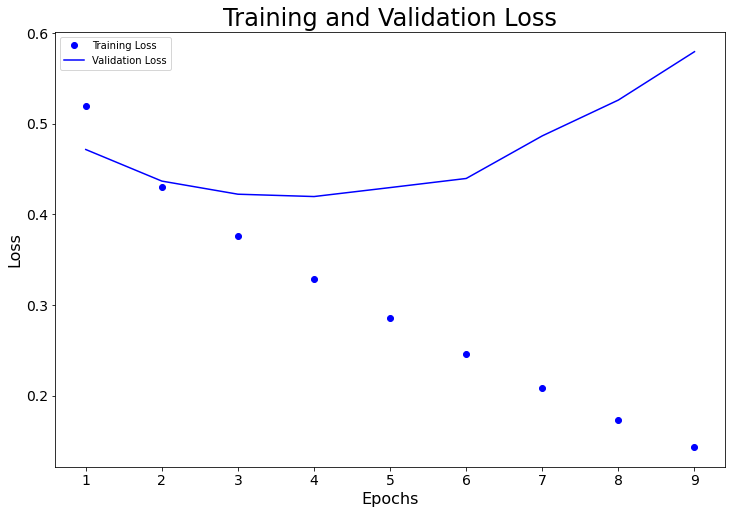

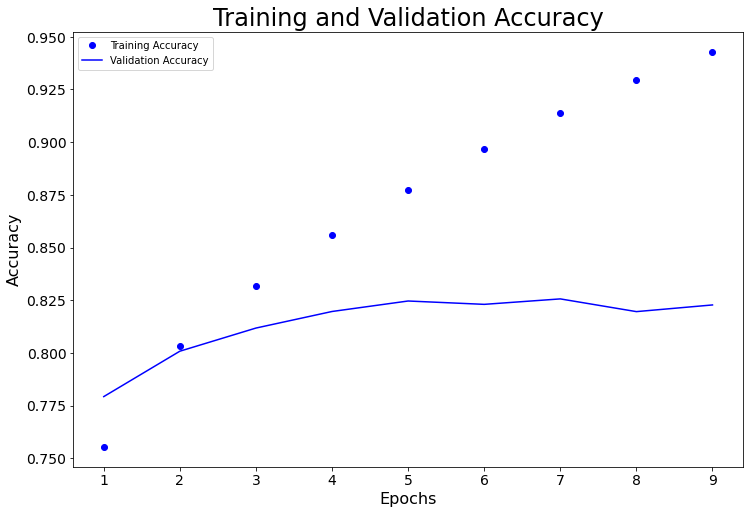

In [33]:
# Extract the best model training history
hist = hist_dict['mod_5_8_8_7'][0]

# Plot the training and validation loss
plot_performance(hist)

# Plot the training and validation accuracy
plot_performance(hist, 'accuracy')

<a id='5'></a>
## 5 Saving training history

In [34]:
def to_pickle(data, filename, base_path=MODEL_PATH):
    """
    Save data as .pkl file.
    """
    filename = os.path.join(base_path, filename)
    outfile = open(filename,'wb')
    pickle.dump(data, outfile)
    outfile.close()

def load_pickle(filename, base_path=MODEL_PATH):
    """
    Load .pkl file.
    """
    filename = os.path.join(base_path, filename)
    infile = open(filename,'rb')
    data = pickle.load(infile)
    infile.close()
    return data

In [35]:
# Save model training history as .pkl files
hist_to_pickle = {}
for k, v in hist_dict.items():
  hist_to_pickle[k] = v[0].history
to_pickle(hist_to_pickle, 'training_history.pkl')

In [36]:
# Save hyperparameters tuning results
scores.to_csv(os.path.join(DATA_PATH, 'tuning_results.csv'), index=False)